In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')
path = 'lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    print("CUDA not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


torch.Size([250, 250, 3])


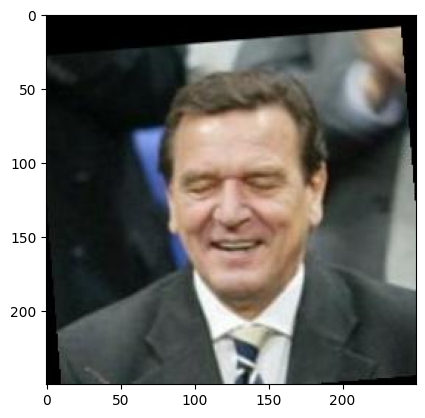

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

# Applications
# 1. AutoEncoders (AEs):
# Dimensionality Reduction: 
Similar to PCA, AEs are often used for reducing the dimensions of data.
# Feature Learning: 
They can learn to encode data into a lower-dimensional space and reconstruct it.
# Denoising: 
AEs are effective in denoising tasks where the goal is to remove noise from data.
# Anomaly Detection: 
They can be used to detect anomalies by learning to reconstruct normal data and failing to reconstruct anomalies accurately.

# 2. Variational AutoEncoders (VAEs):
# Generative Modeling: 
VAEs are primarily used as generative models. They can generate new data samples that resemble the training data.
# Data Interpolation: 
Useful in smoothly interpolating between different data points in the latent space.
# Semi-Supervised Learning: 
They can be used in tasks where only part of the data is labeled.

# Architecture
# 1. AutoEncoders:
Consists of an encoder that maps the input to a latent space and a decoder that reconstructs the input from the latent representation.
The latent space is deterministic, meaning every input is mapped to a fixed point in the latent space.

# 2. Variational AutoEncoders:
Similar encoder-decoder structure, but the encoder in VAEs maps inputs to a distribution over the latent space rather than a single point.
This involves learning the parameters (mean and variance) of a probability distribution.
Includes a sampling step that samples from the distribution to generate different outputs for the same input.

# Loss Function
# 1. AutoEncoders:
The loss function is typically a reconstruction loss, such as mean squared error (MSE), measuring the difference between the input and its reconstruction.

# 2. Variational AutoEncoders:
VAEs have a more complex loss function comprising two parts:

Reconstruction Loss: Similar to AEs, it measures how well the decoder reconstructs the input.
KL Divergence: This is an additional term in the loss function. It measures the divergence between the learned distribution in the latent space and a prior distribution (often a Gaussian). This term ensures that the model learns a well-formed probability distribution in the latent space.

In summary, while both AEs and VAEs have encoder-decoder architectures, the key difference lies in how they treat the latent space and their loss functions. AEs learn a deterministic mapping, whereas VAEs learn a probability distribution, making VAEs more suitable for generative tasks. The addition of the KL Divergence term in the loss function of VAEs also differentiates it from traditional autoencoders.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

**Class Definition**
class VAE(nn.Module): This is a subclass of nn.Module, which is the base class for all neural network modules in PyTorch. VAE stands for Variational Autoencoder.

**Constructor**
def __init__(self, latent_dims=20): This is the constructor for the VAE class. It initializes the VAE with a specified number of latent dimensions (latent_dims), which determines the size of the latent space representation.

**Encoder Network**
The encoder part of the VAE consists of a series of convolutional layers (nn.Conv2d) with ReLU activation functions (nn.ReLU). This part of the network is responsible for compressing the input data into a lower-dimensional latent space. The structure is as follows:
Three convolutional layers, each followed by a ReLU activation function.
The output of the last convolutional layer is flattened to a vector, which is then passed to two different linear layers (self.fc_mu and self.fc_logvar). These layers produce the mean (mu) and log-variance (logvar) of the latent space distribution.

**Reparameterization Trick**
def reparameterize(self, mu, logvar): This function implements the reparameterization trick, which is a key component of VAEs. It allows the model to backpropagate through the stochastic nodes in the network. The function generates a sample from the latent space distribution by adding a random noise (eps) scaled by the standard deviation (std) to the mean (mu).

**Decoder Network**
The decoder part of the VAE reconstructs the input data from the latent space representation. The structure includes:
A linear layer (self.decoder_input) that transforms the latent vector to a higher-dimensional space.
A series of transposed convolutional layers (nn.ConvTranspose2d) with ReLU activation functions to upsample the representation back to the original input size.
The final layer uses a sigmoid activation function to ensure the output values are in the range [0, 1], which is typical for image data.

**Forward Pass**
def forward(self, x): This function defines the forward pass of the VAE. It encodes the input (x), applies the reparameterization trick, and then decodes the result to produce the reconstructed input. It returns the reconstructed input, the mean (mu), and the log-variance (logvar) of the latent distribution.

**Reshaping in the Decoder**
In the decode function, the latent vector is reshaped to match the input shape of the first transposed convolutional layer in the decoder. This reshaping is crucial for the decoder to reconstruct the data properly.

**Overall Workflow**
The VAE takes an input, compresses it into a latent space representation (via the encoder), samples from this space (using the reparameterization trick), and then reconstructs the input from this sampled representation (via the decoder).
This code is a typical implementation of a VAE, particularly suited for image data, given the use of convolutional layers. The VAE is a generative model, allowing it to not only compress and reconstruct data but also generate new data samples similar to those it was trained on.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dims=20):  # Adjust latent_dims to get the desired output shape
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64 * 32 * 32, latent_dims)
        self.fc_logvar = nn.Linear(64 * 32 * 32, latent_dims)

        # Decoder
        self.decoder_input = nn.Linear(latent_dims, 64 * 32 * 32)

        # Adjust the decoder to output an image of size [3, 250, 250]
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),  # Output: [64, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=1),  # Output: [32, 128, 128]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),  # Output: [16, 256, 256]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=1, padding=0),   # Output: [3, 250, 250]
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(h1.size(0), -1)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def decode(self, z):
        h3 = self.decoder_input(z)
        h3 = h3.view(h3.size(0), 64, 32, 32)  # Reshape to match the input shape of the decoder
        return self.decoder(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [20]:
# Instantiate the VAE model
vae = VAE().to(device)

# Load one batch of images
images, _ = next(iter(dataloader))
images = images.to(device)

# Reshape the images if necessary (the VAE expects [batch_size, 3, 250, 250])
# If your images are not of this size, you might need to resize them

# Forward pass through the model
decoded, mu, logvar = vae(images)

# Reparameterize to get latent space samples
std = torch.exp(0.5 * logvar)
eps = torch.randn_like(std)
z = mu + eps * std

# Print the shapes
print("Shape of mu:", mu.shape)
print("Shape of logvar:", logvar.shape)
print("Shape of latent space samples (z):", z.shape)
print("Shape of decoded images:", decoded.shape)

Shape of mu: torch.Size([32, 20])
Shape of logvar: torch.Size([32, 20])
Shape of latent space samples (z): torch.Size([32, 20])
Shape of decoded images: torch.Size([32, 3, 250, 250])


**Shape of Encoder Output:** 
The mu and logvar represent the parameters of the Gaussian distribution in the latent space. Their shape indicates the dimensions of the latent space. For instance, if mu has a shape [batch_size, latent_dims], it means each image in the batch is encoded into a point in a latent_dims-dimensional space.

**Generating New Samples in Latent Space:**
To generate new samples, we use the mu and logvar to define a distribution for each data point in the latent space.
The reparameterization trick (z = mu + eps * std) allows us to sample from this distribution. It involves adding a random noise (eps) scaled by the standard deviation (std) to the mean (mu).
This sampling process is crucial for training VAEs as it introduces a stochastic element that helps in learning a smooth and continuous latent space, which is beneficial for generating new, diverse samples.

**Using the Decoder to Create New Images:**
The decoder takes the sampled latent vector (z) and reconstructs the input data.
If the decoded images have a shape of [batch_size, 3, 250, 250], it confirms that the forward pass through the VAE is working correctly, and the model is capable of reconstructing images of the same size as the input.
By altering the latent vector (z), you can generate variations of the input images, highlighting the generative capability of the VAE.

**Verification of Forward Pass:**
The printed shapes of mu, logvar, z, and decoded are used to verify that each component of the VAE is functioning as expected and producing outputs of the correct dimensions.

In summary, this exercise demonstrates the process of encoding images into a latent space using a VAE, sampling new points from this space, and then decoding these points back into image space. The reparameterization trick is key for enabling gradient-based optimization in the presence of the stochastic sampling process, which is central to the VAE's ability to learn a useful latent representation.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(vae):,} trainable parameters.')

optim = torch.optim.Adam(vae.parameters(), lr=1e-3)

The model has 4,071,867 trainable parameters.


In [24]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

The loss function for a Variational Autoencoder (VAE) typically consists of two main components: the reconstruction loss and the Kullback-Leibler divergence (KLD). Let's break down each term in the provided loss_function and understand their purposes:

**Reconstruction Loss (BCE - Binary Cross Entropy)**

Purpose: This term measures how well the VAE is able to reconstruct the input data. It's a measure of the difference between the original input (x) and the reconstructed output (recon_x).

How It Works: In this case, Binary Cross Entropy (BCE) is used, which is appropriate for data where the values are in the range [0, 1] (like normalized pixel values in images). BCE compares each pixel in the original image with the corresponding pixel in the reconstructed image and penalizes differences between them.

Goal: The goal of this term is to ensure the VAE learns to accurately recreate the input data from the latent space representations. A lower BCE value indicates better reconstruction fidelity.
**Kullback-Leibler Divergence (KLD)**

Purpose: This term regularizes the latent space by penalizing deviations of the learned latent distribution from a prior distribution (typically a standard normal distribution).

How It Works: The KLD measures the difference between two probability distributions: the distribution defined by mu and logvar (representing the encoded distribution of the data) and a standard Gaussian distribution. The formula -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) calculates this divergence.

Goal: The aim is to ensure that the latent space has good properties, like continuity and completeness. This makes the VAE not only good at reconstructing input data but also effective at generating new, plausible data points. It encourages the encoder to distribute the encoded data points in a way that resembles a Gaussian distribution.

**Total Loss**
The total loss is the sum of these two components (BCE and KLD). This combination ensures that the VAE learns to reconstruct data accurately while also maintaining a structured latent space.

**Improvements to the Model**
**Modifying the Architecture:**
Adjust the number of layers, the number of neurons in each layer, or the types of layers (e.g., adding batch normalization) to improve the learning capacity of the model.
Experiment with different activation functions like LeakyReLU instead of ReLU.

**Tuning the Loss Function:**
Introduce a weighting factor to balance the reconstruction loss and the KLD. Sometimes, one may dominate the other, leading to poor overall performance.
Use different types of reconstruction losses depending on the nature of the data (e.g., mean squared error for non-binary data).

**Regularization and Dropout:**
Implement dropout or other regularization techniques to prevent overfitting, especially if the model has a large number of parameters.

**Learning Rate and Optimization:**
Experiment with different learning rates and optimization algorithms (like Adam, RMSprop) to find the most effective combination for training.

**Training Procedure:**
Use techniques like learning rate scheduling or early stopping to enhance the training process.

**Variational Techniques:**
Explore advanced variational techniques, like using different priors for the latent space, to potentially improve the generative quality of the model.

Above changes are done to improve the model for better an accurate results. 

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [83]:
# Number of epochs
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        # Reset gradients
        optim.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = vae(data)

        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        optim.step()

        total_loss += loss.item()

    # Average loss for this epoch
    epoch_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}")

Epoch [1/100], Loss: 97036.7320578681
Epoch [2/100], Loss: 96963.51010425323
Epoch [3/100], Loss: 96896.50934879505
Epoch [4/100], Loss: 96827.82113583139
Epoch [5/100], Loss: 96747.29381657475
Epoch [6/100], Loss: 96669.24411686938
Epoch [7/100], Loss: 96625.29713114754
Epoch [8/100], Loss: 96572.45055526176
Epoch [9/100], Loss: 96509.35382828435
Epoch [10/100], Loss: 96464.31601760218
Epoch [11/100], Loss: 96396.46497506987
Epoch [12/100], Loss: 96351.66362279972
Epoch [13/100], Loss: 96311.31656530936
Epoch [14/100], Loss: 96273.6410062703
Epoch [15/100], Loss: 96220.11251605349
Epoch [16/100], Loss: 96166.28169147088
Epoch [17/100], Loss: 96129.78489272494
Epoch [18/100], Loss: 96085.70103686636
Epoch [19/100], Loss: 96019.8405038906
Epoch [20/100], Loss: 95941.38942925134
Epoch [21/100], Loss: 95857.64988290398
Epoch [22/100], Loss: 95790.21734531994
Epoch [23/100], Loss: 95721.99064176173
Epoch [24/100], Loss: 95660.97523985797
Epoch [25/100], Loss: 95598.74900846113
Epoch [26/10

Each epoch processes the entire dataset in batches, updating the model parameters to minimize the loss. Let's analyze the script and the reported loss values, then discuss troubleshooting strategies if the loss is not decreasing as expected.

**Analysis of the Training Loop**
**Looping Through Epochs:** The script iterates through 100 epochs. In each epoch, it processes the entire dataset in batches.
**Batch Processing:** For each batch, the data is loaded to the appropriate device (CPU or GPU), the VAE performs a forward pass, and the loss is computed.
**Loss Computation:** The loss is calculated using the loss_function, which incorporates both the reconstruction loss and the Kullback-Leibler divergence.
**Backpropagation and Optimization:** The gradients are computed through backpropagation (loss.backward()), and the model parameters are updated (optim.step()).
**Loss Monitoring:** At the end of each epoch, the total loss is averaged and printed. This helps in monitoring the model's performance.

**Interpreting the Loss Values**
The loss values are decreasing over epochs, from 97036.73 in the first epoch to 94199.80 in the 100th epoch. This indicates that the model is learning and improving its ability to reconstruct the input data while regularizing the latent space.

**Steps done to decrease loss of the training:**
**Learning Rate Adjustment:** If the loss isn't decreasing, the learning rate might be too high or too low. Adjusting it can help the optimizer converge more effectively.
**Model Architecture:** Review the model architecture. It might be too simple or too complex for the given task. Adjusting the number of layers or neurons can help.
**Batch Size:** Experiment with different batch sizes. Sometimes smaller or larger batch sizes can make a significant difference.
**Optimizer Choice:** Experiment with different optimizers. While Adam is a good default choice, others like SGD or RMSprop might work better for specific cases.
**Regularization Techniques:** If the model is overfitting, adding dropout layers or other regularization methods can improve training.
**Loss Function Tuning:** Adjust the balance between the reconstruction loss and the KLD term. Sometimes the model might focus too much on one aspect, neglecting the other.

In summary, the provided training loop demonstrates effective learning, as evidenced by the decreasing loss values. However, if the loss does not decrease, various strategies, including adjusting the learning rate, modifying the model architecture, experimenting with different optimizers, and tuning the loss function, can be employed to troubleshoot and improve the model's performance.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

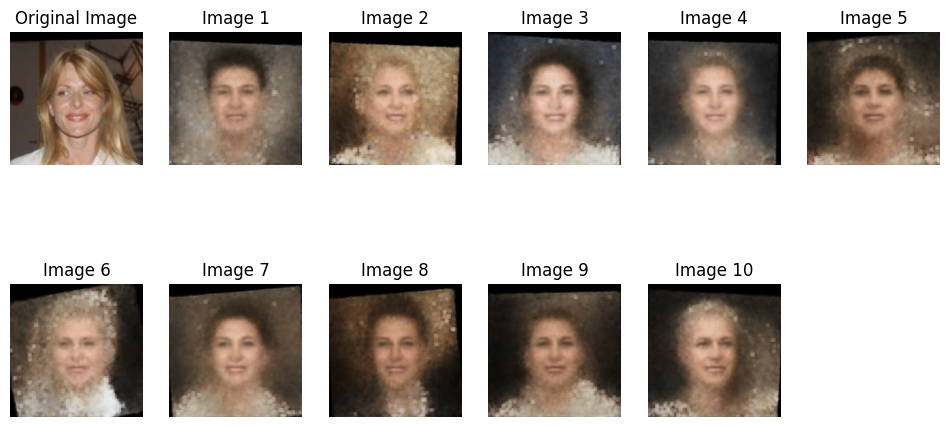

In [96]:
# Set VAE to evaluation mode
vae.eval()

# Select a random image from the dataset
with torch.no_grad():
    data, _ = next(iter(dataloader))
    random_index = random.randint(0, data.size(0) - 1)
    original_image = data[random_index].unsqueeze(0).to(device)  # Add batch dimension

    # Encode the image to get the latent space representation
    mu, logvar = vae.encode(original_image)

    # Reparameterize to sample from the latent space
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std

    # Plot the original image
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 6, 1)
    plt.imshow(original_image.cpu().squeeze().permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')

    # Generate and plot 10 similar images with amplified variations
    for i in range(2, 12):
        # Introduce amplified variation
        z_varied = z + torch.randn_like(z) * 0.5  # Increase the variation factor

        # Decode the varied latent vector
        generated_image_varied = vae.decode(z_varied)

        # Plotting
        plt.subplot(2, 6, i)
        plt.imshow(generated_image_varied.cpu().squeeze().permute(1, 2, 0))
        plt.title(f"Image {i-1}")
        plt.axis('off')

    plt.show()